In [ ]:
# ROSSMANN SALES SOLUTION

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

IMPORTS

In [1]:
!pip install bentoml

  Using cached https://files.pythonhosted.org/packages/ab/18/b4ae146ef04a3514672b4ed5ffe9a5adb06cd85d027734c96c91b02dedbc/BentoML-0.3.0-py3-none-any.whl


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path
import PIL
import json
from fastai import *
from fastai.tabular import *



**LOAD KAGGLE DATASET**

In [4]:
PATH = Path('rossmann/')
PATH


PosixPath('rossmann')

In [11]:
!ls

README.md                   rossmann_sales.py
models                      test_clean.csv
models.zip                  train_clean.csv
rossman_data_clean.ipynb    train_clean.csv.zip
rossman_sales.ipynb         trained_model.pth
rossman_sales_bentoml.ipynb


**LOAD INTO DATAFRAME**

In [13]:
train_df = pd.read_csv('train_clean.csv')

In [15]:
test_df = pd.read_csv('test_clean.csv')

In [16]:
procs = [FillMissing, Categorify, Normalize]

In [17]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [18]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()

In [19]:
test_df['Date'].min(), test_df['Date'].max()

('2015-08-01', '2015-09-17')

In [20]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()
cut

41395

In [21]:
valid_idx = range(cut)

In [24]:
df[dep_var].head()

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [25]:
train_df.head()

,Unnamed: 0,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,...,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,0,0,1,5,2015-07-31,5263,555,1,1,False,...,57.0,0.0,0.0,0.0,5.0,0.0,5.0,7.0,0.0,5.0
1,1,1,2,5,2015-07-31,6064,625,1,1,False,...,67.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0,0.0,1.0
2,2,2,3,5,2015-07-31,8314,821,1,1,False,...,57.0,0.0,0.0,0.0,5.0,0.0,5.0,5.0,0.0,5.0
3,3,3,4,5,2015-07-31,13995,1498,1,1,False,...,67.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0,0.0,1.0
4,4,4,5,5,2015-07-31,4822,559,1,1,False,...,57.0,0.0,0.0,0.0,5.0,0.0,5.0,1.0,0.0,1.0


In [26]:
data = (TabularList.from_df(df, path=PATH, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                .add_test(TabularList.from_df(test_df, path=PATH, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())


In [27]:
print(data.train_ds.cont_names)  

['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE', 'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']


In [28]:
(cat_x,cont_x),y = next(iter(data.train_dl))
for o in (cat_x, cont_x, y): print(to_np(o[:5]))

[[458   6   1   1 ...   1   1   1   1]
 [735   3   1   1 ...   1   1   1   1]
 [334   4   1   1 ...   1   1   1   1]
 [536   5   1   4 ...   1   1   1   1]
 [847   2   1   4 ...   1   1   1   1]]
[[-0.263889 -1.50742  -1.645094 -1.315092 ...  1.654549 -0.269147 -0.880569 -0.387468]
 [-0.452271 -1.329946 -1.229165 -0.901096 ...  1.172916 -1.160119 -0.880569 -0.387468]
 [-0.18059  -1.684893 -1.437129 -0.694097 ...  1.590332 -0.447341  1.135616 -0.387468]
 [-0.09601   2.396997  1.890303  0.961889 ... -0.62518   0.889117 -0.880569 -0.387468]
 [-0.673974  0.799736  1.058445  1.168887 ... -0.62518   0.710922  1.135616 -0.387468]]
[9.10498  8.380916 8.633909 8.981682 8.977525]


DEFINING THE MODEL

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [30]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [31]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [32]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(2, 2)
    (3): Embedding(5, 4)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(17, 8)
    (15): Embedding(17, 8)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
    (24): Embedding(3, 3)
    (25): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=227, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentu

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


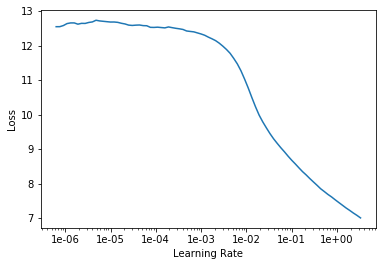

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(1, 1e-04 , wd = 0.2)
#wd=0.2


epoch,train_loss,valid_loss,exp_rmspe,time
0,0.055021,0.072887,0.283810,00:45


In [35]:
learn.show_results()

Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,PromoInterval,CompetitionOpenSinceYear,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_fw,StateHoliday_bw,SchoolHoliday_fw,SchoolHoliday_bw,CompetitionDistance_na,CloudCover_na,AfterStateHoliday_na,BeforeStateHoliday_na,CompetitionDistance,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Max_Humidity,Mean_Humidity,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,target,prediction
1,5,2015,#na#,31,False,24.0,0.0,c,a,#na#,2008,1900,HE,#na#,Fog,5.0,5.0,0.0,0.0,7.0,5.0,False,False,False,False,-0.5356,1.1547,1.0584,0.5479,0.8495,-0.9590,-1.2146,-0.0086,-0.1042,-2.6183,1.5460,2.0817,0.9482,0.8891,1.1356,2.5808,8.568457,[8.893487]
2,5,2015,#na#,31,False,24.0,25.0,a,a,"Jan,Apr,Jul,Oct",2007,2010,TH,#na#,Fog,1.0,5.0,0.0,0.0,1.0,5.0,False,False,False,False,-0.6253,0.4448,0.4346,0.3409,1.0810,-0.2600,-0.7411,-1.0110,-0.1042,-0.8137,1.0425,2.0817,1.2692,0.8891,1.1356,2.5808,8.710125,[8.820939]
3,5,2015,#na#,31,False,24.0,25.0,a,a,"Jan,Apr,Jul,Oct",2006,2011,NW,#na#,Fog,5.0,5.0,0.0,0.0,5.0,5.0,False,False,False,False,1.1125,0.7997,0.4346,0.1339,1.0810,-0.3474,-0.8088,-1.0110,-1.1302,-2.0167,1.6467,2.0817,0.9482,0.8891,1.1356,2.5808,9.025696,[9.101529]
4,5,2015,#na#,31,False,24.0,0.0,c,c,#na#,2009,1900,BE,#na#,#na#,1.0,5.0,0.0,0.0,1.0,5.0,False,False,False,False,-0.6189,0.4448,0.6425,0.7549,0.3865,-0.3474,-0.4030,-0.1088,0.7509,0.3893,0.4384,2.0817,1.2692,0.8891,1.1356,2.5808,9.546455,[9.271607]
5,5,2015,#na#,31,False,3.0,0.0,a,a,#na#,2015,1900,SN,#na#,#na#,1.0,5.0,0.0,0.0,1.0,5.0,False,False,False,False,3.1347,0.6223,0.8505,0.9619,-1.0025,-0.8716,-0.6735,-1.0110,-0.1042,-0.8137,1.2439,2.0817,0.9482,0.8891,1.1356,2.5808,8.480944,[9.122861]


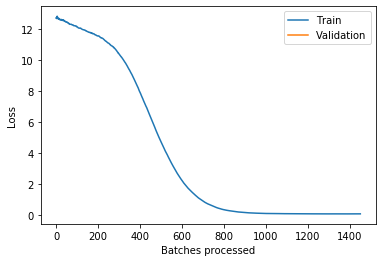

In [36]:
learn.recorder.plot_losses()

In [37]:
row = df.iloc[0]

In [38]:
learn.predict(row)

(FloatItem [8.893487], tensor([8.8935]), tensor([8.8935]))

In [39]:
test_df.to_csv('test_clean.csv')

In [40]:
!ls

README.md                   rossmann
models                      rossmann_sales.py
models.zip                  test_clean.csv
rossman_data_clean.ipynb    train_clean.csv
rossman_sales.ipynb         train_clean.csv.zip
rossman_sales_bentoml.ipynb trained_model.pth


In [41]:
%%writefile rossmann_sales.py

from bentoml import BentoService, api, env, artifacts
from bentoml.artifact import FastaiModelArtifact
from bentoml.handlers import DataframeHandler

#@env(conda_pip_dependencies=['fastai'])
@env(conda_environment=['fastai'])
@artifacts([FastaiModelArtifact('rossmann')])

class RossmannSales(BentoService):
    
    @api(DataframeHandler)
    def predict(self,df):
        result = []
        for index, row in df.iterrows():            
            result.append(self.artifacts.rossmann.predict(row))
        return str(result)

Overwriting rossmann_sales.py


In [42]:
from rossmann_sales import RossmannSales

service = RossmannSales.pack(rossmann=learn)
saved_path = service.save('/tmp/bento_archive')

print(saved_path)

[2019-07-21 20:26:03,944] INFO - Searching for dependant modules of rossmann_sales:/Users/bozhaoyu/src/scrap/RossmanSales/rossmann_sales.py
[2019-07-21 20:26:25,900] INFO - Copying local python module '/Users/bozhaoyu/src/scrap/RossmanSales/rossmann_sales.py'
[2019-07-21 20:26:25,902] INFO - Done copying local python dependant modules
[2019-07-21 20:26:26,022] INFO - BentoService RossmannSales:2019_07_21_9dbf9dec saved to /tmp/bento_archive/RossmannSales/2019_07_21_9dbf9dec
/tmp/bento_archive/RossmannSales/2019_07_21_9dbf9dec


In [43]:
!pip install {saved_path}

Processing /tmp/bento_archive/RossmannSales/2019_07_21_9dbf9dec
  Stored in directory: /private/var/folders/kn/xnc9k74x03567n1mx2tfqnpr0000gn/T/pip-ephem-wheel-cache-pad17pic/wheels/d3/c6/48/2499714d244ed6890f3887e38180397699ed5c716fec5a5729
Successfully built RossmannSales


In [46]:
!RossmannSales info

{
  "name": "RossmannSales",
  "version": "2019_07_21_9dbf9dec",
  "apis": [
    "predict"
  ]
}


In [50]:
c = df.iloc[0:4]
print(c)
c.to_csv('./small_test.csv')

   Store  DayOfWeek  Year  Month  Day  StateHoliday  CompetitionMonthsOpen  \
0      1          5  2015      7   31         False                   24.0   
1      2          5  2015      7   31         False                   24.0   
2      3          5  2015      7   31         False                   24.0   
3      4          5  2015      7   31         False                   24.0   

   Promo2Weeks StoreType Assortment  ... Mean_Wind_SpeedKm_h  CloudCover  \
0          0.0         c          a  ...                  11         1.0   
1         25.0         a          a  ...                  11         4.0   
2         25.0         a          a  ...                   5         2.0   
3          0.0         c          c  ...                  16         6.0   

   trend trend_DE  AfterStateHoliday BeforeStateHoliday  Promo  SchoolHoliday  \
0     85       83               57.0                0.0      1              1   
1     80       83               67.0                0.0      1    

In [51]:
!RossmannSales predict --input=small_test.csv

[(FloatItem [8.893487], tensor([8.8935]), tensor([8.8935])), (FloatItem [8.820939], tensor([8.8209]), tensor([8.8209])), (FloatItem [9.101529], tensor([9.1015]), tensor([9.1015])), (FloatItem [9.271607], tensor([9.2716]), tensor([9.2716]))]


In [ ]:
!bentoml serve {saved_path}

 * Serving Flask app "RossmannSales" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [21/Jul/2019 22:35:25] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Jul/2019 22:35:27] "GET /docs.json HTTP/1.1" 200 -
127.0.0.1 - - [21/Jul/2019 22:35:35] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [21/Jul/2019 22:35:45] "GET /predict HTTP/1.1" 400 -


In [ ]:
#!docker login -u="southsidesilva" -p="southsidesilva"

In [ ]:
#!cd {saved_path} && docker build . -t rossmann_sales

In [ ]:
#!docker run -p 5000:5000  rossmann_sales